In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,6)

# Assignment
Familiarity with several pricing models and how to apply them to a portfolio. Now calculate the VWAP, Sharpe and Alpha for your portfolio from the start of the semester  to the date of you calculations. Your calculation results and the VaR calculations that you performed last week are the main content of the Portfolio Review presentation that is next week's subject and assignment. -- Remember Presentation is Important

# Variables

In [17]:
start_date = datetime(2022, 1, 1)
end_date = datetime.now()
alpha = 0.05
period = '1d'
interval = '15m'

# Functions

# Load Data

## Load Variables

var_lst = ['^TNX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
#rf_rate = round((data.mean() / 100),4)
rf_rate = round((data.mean()),4)
rf_rate

## Load Portfolio

In [18]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w6/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })

folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class','Sub_Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)

# calculate portfilio percentage
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

print('folio_df: ', folio_df.shape)

folio_df:  (35, 7)


In [19]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


In [20]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83719000.0

# Portfolio

## Load Pricing Time Series

In [21]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']
data = pdr.get_data_yahoo(ticker_lst, period=period, interval=interval)[['Close', 'Volume']]
price_df = data['Close']
volumne_df = data['Volume']


price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


2 Failed downloads:
['PEX']: Exception('%ticker%: No price data found, symbol may be delisted (period=1d)')
['C_A_S_H']: Exception('%ticker%: No data found, symbol may be delisted')



price_df #: (26, 35)
return_df #: 35


## Portfolio Returns

In [22]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

return_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_df #:', return_df.shape)

port_ret_weighted #: (26, 35)
return_df #: (26, 36)


# Calculate Portfolio Value

In [23]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
#shares_df[['Shares']].round(0)
shares_df.head()

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,469,000.0000"
DFAR,"108,467.0000"


In [24]:
m_df = price_df.copy()
m_df.reset_index(names=['Date'],inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

,Date,Ticker,Price
0,2023-10-06 09:30:00,ALTVX,9.0900
1,2023-10-06 09:45:00,ALTVX,NaN
2,2023-10-06 10:00:00,ALTVX,NaN
3,2023-10-06 10:15:00,ALTVX,NaN
4,2023-10-06 10:30:00,ALTVX,NaN


In [25]:
v_df = volumne_df.copy()
v_df.reset_index(names=['Date'],inplace=True)
v_df = v_df.melt(id_vars=['Date'])
v_df.columns = ['Date','Ticker','Volume']
v_df.head()

,Date,Ticker,Volume
0,2023-10-06 09:30:00,ALTVX,0.0000
1,2023-10-06 09:45:00,ALTVX,NaN
2,2023-10-06 10:00:00,ALTVX,NaN
3,2023-10-06 10:15:00,ALTVX,NaN
4,2023-10-06 10:30:00,ALTVX,NaN


In [26]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

l_df:  (35, 3)


In [27]:
merge_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker').merge(shares_df,how='left' ,left_on='Ticker', right_on='Ticker')
merge_df['share_value'] = merge_df['Price'] * merge_df['Shares']
merge_df['perc_share_value'] = merge_df.groupby(['Ticker'])[['share_value']].pct_change()

print('merge_df: ',merge_df.shape)
#merge_df.head()

merge_df:  (910, 8)


In [28]:
merge_df = merge_df.merge(v_df, how='left', left_on=['Ticker','Date'], right_on=['Ticker','Date']) 
merge_df.sort_values(by=['Ticker','Date'], inplace=True)
print('merge_df:', merge_df.shape)

merge_df: (910, 9)


In [29]:
folioValue_df = merge_df.groupby(['Date'])[['share_value']].sum().reset_index()
folioValue_df['pct_change'] = folioValue_df['share_value'].pct_change()
folioValue_df = folioValue_df[1:]

print('folioValue_df: ',folioValue_df.shape)

folioValue_df:  (25, 3)


## Graph Porfolio Values

t_df:  (260, 4)


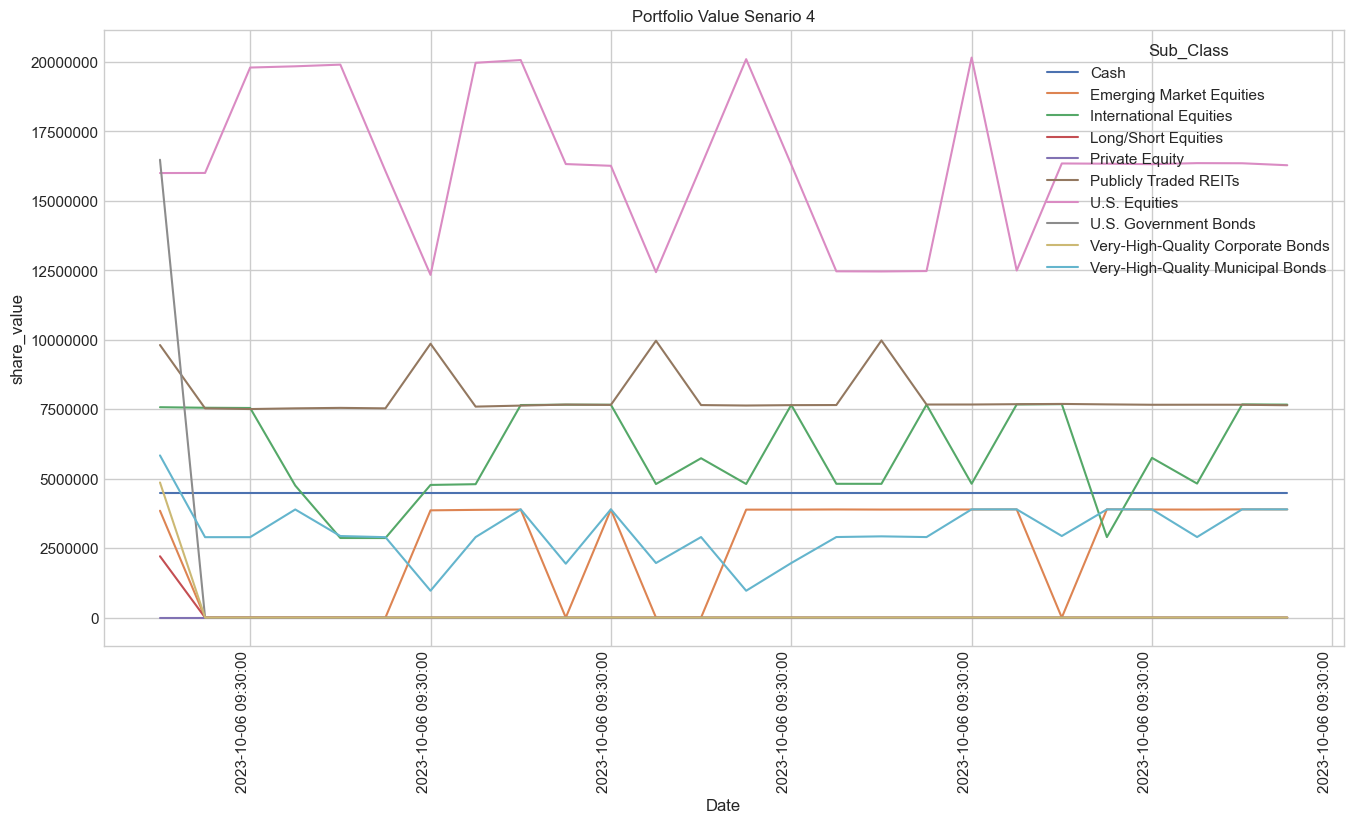

In [30]:
t_df = merge_df.groupby(['Date','Class','Sub_Class'])[['share_value']].sum().reset_index()
t_df.sort_values(by=['Date'], inplace=True)
print('t_df: ',t_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="share_value", hue='Sub_Class')
#g.set_yticklabels(['{:,.1f}'.format(x) + ' M' for x in g.get_yticks()/1000000])
ax.set_xticklabels(labels=t_df['Date'], rotation=90, ha='right')

ax.set(title='Portfolio Value Senario 4');

# Value Weighted Average Price (VWAP)

In [31]:
merge_df['Cum_Volume'] = merge_df.groupby('Ticker')['Volume'].transform(pd.Series.cumsum)
merge_df['VWAP'] = merge_df['Price'] * merge_df['Cum_Volume'] / merge_df['Cum_Volume'] 
print('merge_df: ', merge_df.shape)

merge_df:  (910, 11)


t_df:  (35, 2)


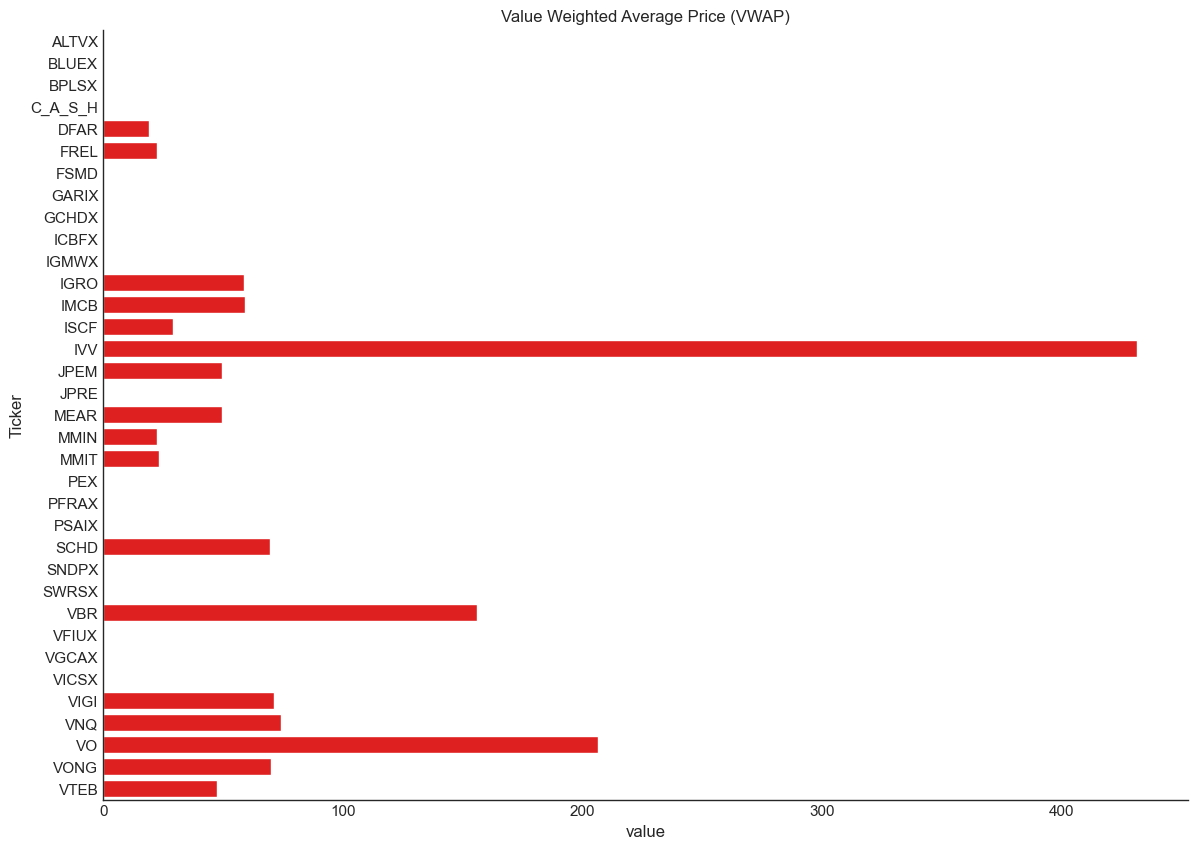

In [32]:
t_df = merge_df[['Date','Ticker','VWAP']].pivot(index='Date', columns='Ticker')[-1:]
t_df = t_df['VWAP'].melt()
print('t_df: ', t_df.shape)

fig, ax = plt.subplots(figsize=(14,10))
g = sns.barplot(x='value', y='Ticker', color='red',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Value Weighted Average Price (VWAP)');

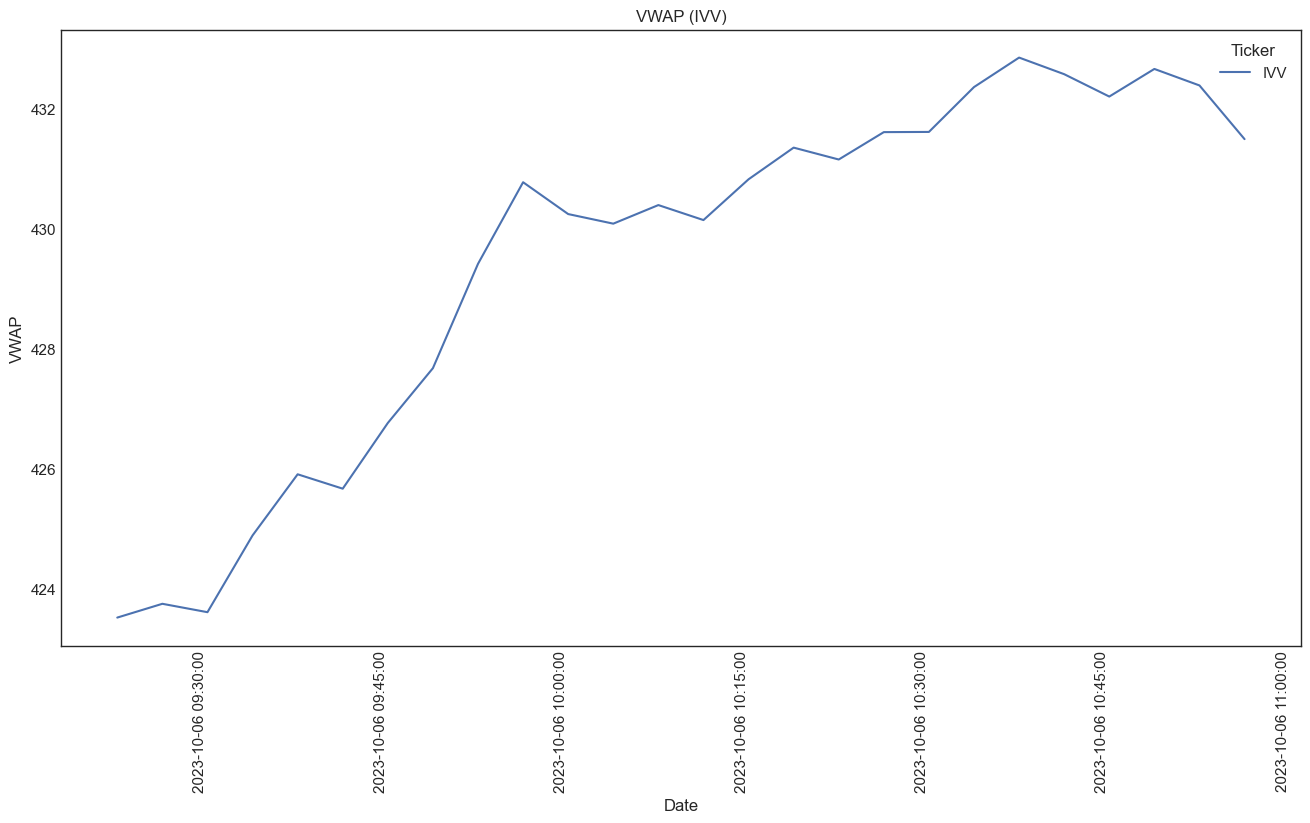

In [33]:
t_df = merge_df[merge_df['Ticker'] == 'IVV']
#t_df = merge_df[merge_df['Ticker'].isin(['IVV','VO'])]

# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="VWAP", hue='Ticker')
ax.set_xticklabels(labels=t_df['Date'], rotation=90, ha='right')

ax.set(title='VWAP (IVV)');

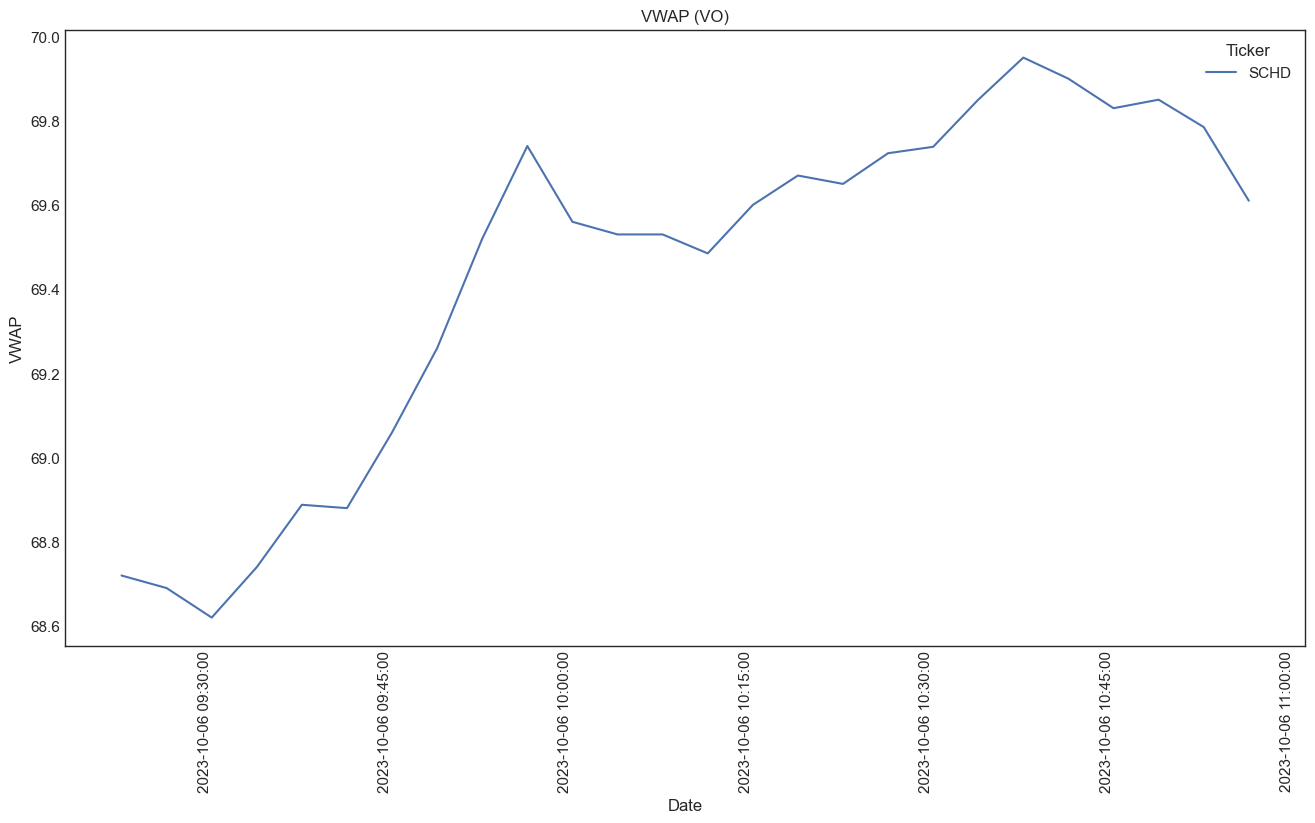

In [34]:
t_df = merge_df[merge_df['Ticker'] == 'SCHD']
#t_df = merge_df[merge_df['Ticker'].isin(['IVV','VO'])]

# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="VWAP", hue='Ticker')
ax.set_xticklabels(labels=t_df['Date'], rotation=90, ha='right')

ax.set(title='VWAP (VO)');

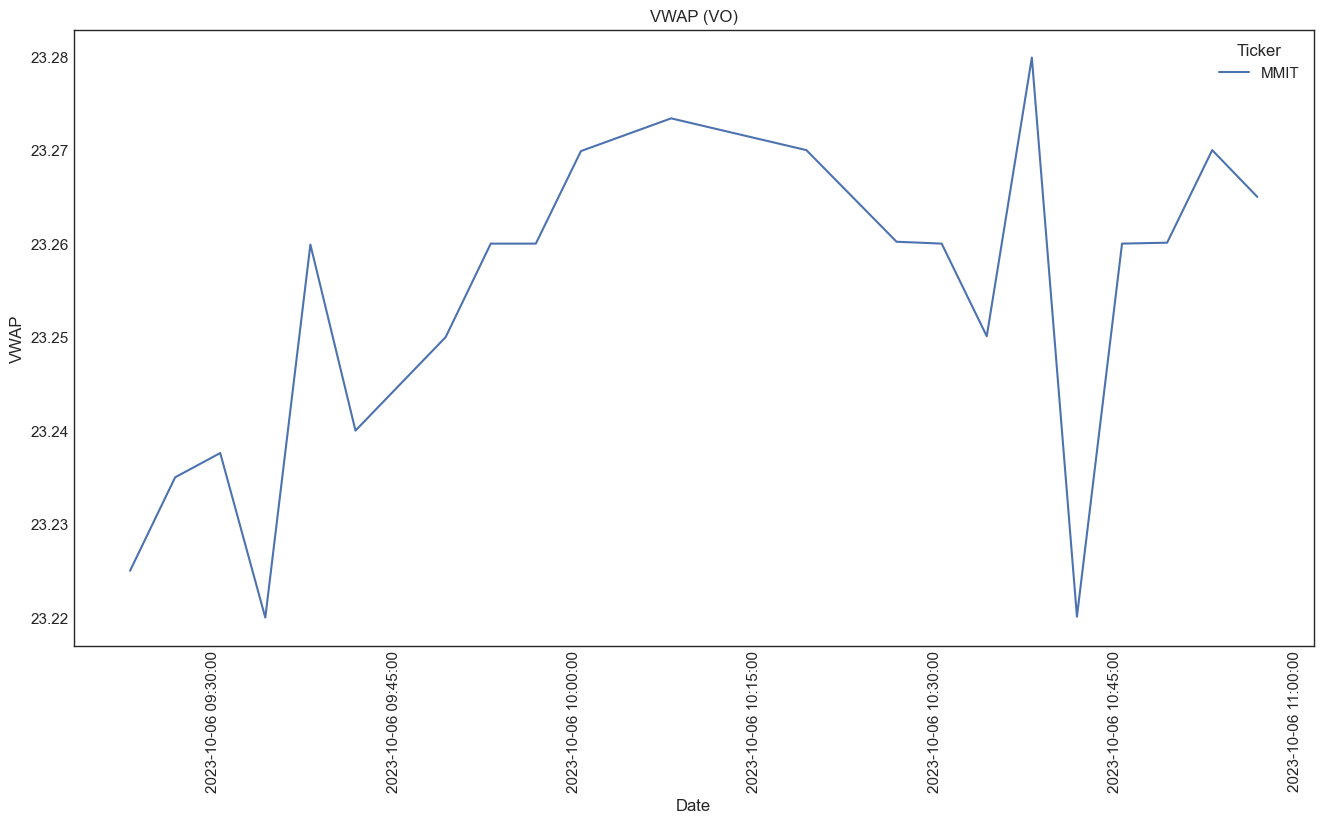

In [35]:
t_df = merge_df[merge_df['Ticker'] == 'MMIT']
#t_df = merge_df[merge_df['Ticker'].isin(['IVV','VO'])]

# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="VWAP", hue='Ticker')
ax.set_xticklabels(labels=t_df['Date'], rotation=90, ha='right')

ax.set(title='VWAP (VO)');

In [36]:
merge_df['Ticker'].unique()

array(['ALTVX', 'BLUEX', 'BPLSX', 'C_A_S_H', 'DFAR', 'FREL', 'FSMD',
       'GARIX', 'GCHDX', 'ICBFX', 'IGMWX', 'IGRO', 'IMCB', 'ISCF', 'IVV',
       'JPEM', 'JPRE', 'MEAR', 'MMIN', 'MMIT', 'PEX', 'PFRAX', 'PSAIX',
       'SCHD', 'SNDPX', 'SWRSX', 'VBR', 'VFIUX', 'VGCAX', 'VICSX', 'VIGI',
       'VNQ', 'VO', 'VONG', 'VTEB'], dtype=object)

In [37]:
t_df = merge_df[merge_df['Ticker'] == 'MMIT']
t_df

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,perc_share_value,Volume,Cum_Volume,VWAP
494,2023-10-06 09:30:00,MMIT,23.2250,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","970,131.4909",NaN,304.0000,304.0000,23.2250
495,2023-10-06 09:45:00,MMIT,23.2350,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","970,549.2105",0.0004,374.0000,678.0000,23.2350
496,2023-10-06 10:00:00,MMIT,23.2376,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","970,657.8032",0.0001,"1,980.0000","2,658.0000",23.2376
497,2023-10-06 10:15:00,MMIT,23.2200,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","969,922.5913",-0.0008,"5,000.0000","7,658.0000",23.2200
498,2023-10-06 10:30:00,MMIT,23.2599,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","971,589.2470",0.0017,"16,080.0000","23,738.0000",23.2599
499,2023-10-06 10:45:00,MMIT,23.2400,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","970,758.0304",-0.0009,"2,688.0000","26,426.0000",23.2400
500,2023-10-06 11:00:00,MMIT,NaN,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000",NaN,0.0000,NaN,NaN,NaN
501,2023-10-06 11:15:00,MMIT,23.2500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","971,175.7500",0.0004,"4,363.0000","30,789.0000",23.2500
502,2023-10-06 11:30:00,MMIT,23.2600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","971,593.4696",0.0004,"4,748.0000","35,537.0000",23.2600
503,2023-10-06 11:45:00,MMIT,23.2600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"41,771.0000","971,593.4696",0.0000,849.0000,"36,386.0000",23.2600
